In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

#import geopandas as gpd
#from shapely import geometry
#from geopandas import GeoSeries, GeoDataFrame

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
#import statsmodels.api as sm

from textwrap import wrap

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import scale, StandardScaler
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import TimeSeriesSplit

# Import Data

In [3]:
#read data in from pickle file
df = pd.read_pickle('C:/Users/Stacey/Downloads/NY_complaint_data_for_model_prec62.pkl')

In [4]:
df.shape

(132, 7)

In [5]:
df.head(1)

,CMPLNT_FR_DATE_YEAR,CMPLNT_FR_DATE_MONTH,BORO,LAW_CAT_CD,OFNS_DESC,CAT_OFNS,CMPLNT_NUM_count
4,2006,1,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,19


# Model crime incidence with basic Time Series
P = centroid of precinct 75 (the highest crime precinct in the city)  
R = 0.5 miles (2640 feet)  
O = Grand Larceny (felony with the highest incidence in all boroughs)  

Notes: points in lower crime precincts as well as lower incidence crime types will likely require a larger radius to model as there won't be as many crimes within a half mile radius.  

In [6]:
#rename columns
df.rename(columns={'CMPLNT_FR_DATE_YEAR':'YEAR',
 'CMPLNT_FR_DATE_MONTH':'MONTH',
 'LAW_CAT_CD':'CRIME_CAT',
 'OFNS_DESC':'OFFENSE',
 'CMPLNT_NUM_count':'COUNT'}, inplace = True)

In [7]:
df.head(1)

,YEAR,MONTH,BORO,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT
4,2006,1,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,19


** Set up as a time series **

In [8]:
#create a date (set date for each month as 1st of the month)
df['DAY'] = 1 
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

In [9]:
#order by date
df = df.sort_values('DATE')

In [10]:
df.head(5)

,YEAR,MONTH,BORO,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT,DAY,DATE
4,2006,1,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,19,1,2006-01-01
29,2006,2,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,12,1,2006-02-01
55,2006,3,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,17,1,2006-03-01
79,2006,4,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,13,1,2006-04-01
100,2006,5,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,12,1,2006-05-01


In [11]:
#check that there is an observation for all 132 months(12 months * 11 years)
len(df.DATE.unique()), len(df)

(132, 132)

In [12]:
#set up a new dataframe
dfM = df.copy()

In [13]:
#Difference by 1 and view time series and resulting auto correlation
dfM['COUNT_s1'] = dfM['COUNT'].shift(1)
dfM['diff_1'] = df.COUNT - dfM.COUNT_s1
dfM.head(5)

,YEAR,MONTH,BORO,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT,DAY,DATE,COUNT_s1,diff_1
4,2006,1,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,19,1,2006-01-01,NaN,NaN
29,2006,2,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,12,1,2006-02-01,19.0,-7.0
55,2006,3,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,17,1,2006-03-01,12.0,5.0
79,2006,4,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,13,1,2006-04-01,17.0,-4.0
100,2006,5,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,12,1,2006-05-01,13.0,-1.0


# Baseline model/ Transform the data for supervised learning predicting one Month ahead
For Time Series Model the naive model is used as the baseline: the value at the previous time step (t-1) is used to predict the expected outcome at the next time step (t+1)
  
Example:  Predict Jan if Dec is known  
Actual = Jan 2016  
Prediction = Dec 2015    

In [14]:
#Create the target variable: t+1 
#for the Jan observation: y = t+1 = Jan, X = t = Dec
dfM['t+1'] = dfM['COUNT']  #X
dfM['t'] = dfM['COUNT_s1']  #y

In [15]:
dfM.head(3)

,YEAR,MONTH,BORO,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT,DAY,DATE,COUNT_s1,diff_1,t+1,t
4,2006,1,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,19,1,2006-01-01,NaN,NaN,19,NaN
29,2006,2,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,12,1,2006-02-01,19.0,-7.0,12,19.0
55,2006,3,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,17,1,2006-03-01,12.0,5.0,17,12.0


In [16]:
#holdout set = 2016
training = dfM[dfM.YEAR <= 2015].dropna() #first row will be dropped
holdout = dfM[dfM.YEAR == 2016].dropna()

In [17]:
len(training), len(holdout)

(119, 12)

In [18]:
holdout.head(1)

,YEAR,MONTH,BORO,CRIME_CAT,OFFENSE,CAT_OFNS,COUNT,DAY,DATE,COUNT_s1,diff_1,t+1,t
2575,2016,1,BROOKLYN,FELONY,GRAND LARCENY,FELONY-GRAND LARCENY,8,1,2016-01-01,12.0,-4.0,8,12.0


# Evaluate the Baseline Model

In [19]:
#plot model vs. actual
def plot_model_results(train,test,actual_col,model_col,model_name):
    plt.figure() #set up new plot
    #Plot model vs actual
    plt.plot_date(train.DATE,train[actual_col],fmt='Y',color='steelblue')
    plt.plot_date(test.DATE,test[model_col], '--', color = 'red')
    plt.plot_date(test.DATE,test[actual_col],color='green',fmt='Y')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45) 
    plt.title(model_name + ' Model vs Actual')

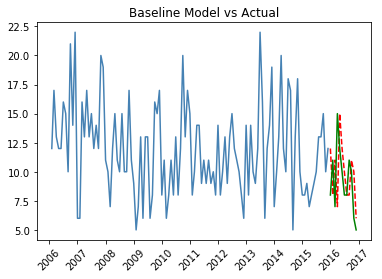

In [20]:
plot_model_results(training,holdout,'t+1','t','Baseline')

In [21]:
#Calculate Forecast Error, Mean Forecast Error (Forecast Bias), 
#MAE (mean abs error), MAPE (mean absolute perecent error), 
#MSE (mean sq error), RMSE (root MSE) on the test set
def model_eval(train,test,actual_col,model_col,model_name):
    FE = test[actual_col] - test[model_col] #forecast error (series)
    FB = np.mean(FE)  #forecast bias: can be pos or neg, ideal is 0
    MAE = mean_absolute_error(test[actual_col],test[model_col]) #0 indicates no error
    #MAPE = sum(abs(FE)/abs(test[actual_col]))/len(test[actual_col])*100
    MSE = mean_squared_error(test[actual_col],test[model_col]) #0 indicates no error
    RMSE = MSE ** 0.5 #same units as prediction
    print('Performance Measures: '+model_name + ' Model')
    print('Forecast Bias = {:.2f}, MAE = {:.2f}, MSE = {:.2f}, RMSE = {:.2f}'.format(FB,MAE,MSE,RMSE))


In [22]:
model_eval(training,holdout,'t+1','t','Baseline')

Performance Measures: Baseline Model
Forecast Bias = -0.58, MAE = 2.92, MSE = 12.42, RMSE = 3.52


# Creat a simple regression model
Create a simple regression model with "t+1" as the target (y) and "t" as the feature (X)

**Identify features and target **

In [23]:
#Identify features and target
training_X = training[['t']]
training_y = training[['t+1']]

holdout_X = holdout[['t']]
holdout_y = holdout[['t+1']]

In [24]:
#number of observations in each set
n_training = len(training_X)
n_holdout = len(holdout_X)
print(n_training,n_holdout)

119 12


**Scale the features **

In [25]:
#use the training set to create a standard scaler for validation 
#and test sets, finds the mean and standard deviation of the train set
scaler_M7 = StandardScaler().fit(training_X)

In [26]:
#transform the features for all sets using the scaler created from the 
#train set, this will subtract the mean to center the data and 
#divide by the standard deviation to scale it
training_X_scaled = scaler_M7.transform(training_X)
holdout_X_scaled = scaler_M7.transform(holdout_X)
len(training_X_scaled),len(holdout_X_scaled)

(119, 12)

** Implement Linear Regression **

In [27]:
#create a linear regression model
regr_M7 = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

** Evaluate the model by varying window size **  
Evaluate how much data should the model be trained on.

In [30]:
#get the RMSE (for predicted residuals) for a specified training set size
#using a sliding window to predict a test size of 1
#Walk forward validation
def ts_kfold(min_train,max_train,model):  #test size is 1 (n_training-1)
    test_pred_list = [] #store the test predictions of each ts-kfold
    splits = TimeSeriesSplit(n_splits=n_training-1,
                             max_train_size = max_train)
    for train_index, test_index in splits.split(training_X):
        if len(train_index) >= min_train:
            #print(train_index, test_index)
            train_set_X = training_X_scaled[train_index]
            train_set_y = training_y.values[train_index]
            test_set_X = training_X_scaled[test_index]
            test_set_y = training_y.values[test_index]
            
            #fit the regression model on the train set
            model.fit(train_set_X, train_set_y)
            
            #predict the target values of the test set
            test_pred = model.predict(test_set_X)
            
            #add the prediction to the list
            test_pred_list.append(test_pred[0])
            
    #Calculate RMSE on the validation set
    RMSE = mean_squared_error(test_pred_list,training_y[min_train:]) ** 0.5

    return(RMSE)

In [35]:
#get the MSE for windows in multiples of 3 from 3 to the size of the training set
#calculate RMSE for each and plot
RMSE_list = []
W =[i for i in range(n_training)[3::3]]
#print(W)

for w in W:
    RMSE_w = ts_kfold(w,w,regr_M7)
    RMSE_list.append(RMSE_w)

In [38]:
RMSE_list[:10]

[8.52651070250643,
 4.8704344745177526,
 4.4476025993885173,
 4.1407225211545837,
 3.8738273310756366,
 3.947864111555393,
 4.019925786500111,
 3.9540282621783267,
 3.8957958015400482,
 3.9456704421977427]

Text(0.5,1,'RMSE by window')

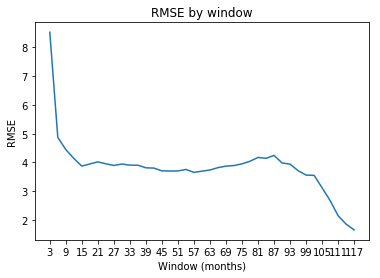

In [33]:
#plot the predicted MSE from the walk forward validation
plt.plot(W,RMSE_list)
plt.xticks(np.arange(min(W),max(W)+1,6.0))
plt.ylabel('RMSE')
plt.xlabel('Window (months)')
plt.title('RMSE by window')

Minimum RMSE is at window = 15 months
  
There are lower values at the end but those are a result of very few cross validations because larger window sizes don't allow for many training sets of that size.

** Get the RMSE for the Walk Forward Validation for the regression model with a window of 15 **

In [45]:
#Walk Forward Validation RMSE when the window is 15
#(similar to leave one out cross-validation, but for time series)
#provides insight into how well the model would perform on unseen data
RMSE_list[W.index(15)]

3.8738273310756366

** Using a window of 15 months and fitting a linear regression with one feature (number of crimes in the previous time period), the model can be retrained as new data becomes available **

** Get the RMSE for 2016 to compare to the baseline model **

In [40]:
#generate model with window = 12, feature = prior month, predict next month

def ts_walk_forward(X,y,min_train,max_train,model):  #test size is 1 (n_training-1)
    test_pred_list = [] #store the test predictions of each ts-step
    splits = TimeSeriesSplit(n_splits=len(X)-1,
                             max_train_size = max_train)
    for train_index, test_index in splits.split(X):
        if len(train_index) >= min_train:
            #print(train_index, test_index)        
            train_set_X = X[train_index]
            train_set_y = y[train_index]
            test_set_X = X[test_index]
            test_set_y = y[test_index]
            
            #fit the regression model on the train set
            model.fit(train_set_X, train_set_y)
            
            #predict the target values of the test set
            test_pred = model.predict(test_set_X)
            
            #add the prediction to the list
            test_pred_list.append(test_pred[0])
            
    #Calculate RMSE on the validation set
    RMSE = mean_squared_error(test_pred_list,y[min_train:]) ** 0.5

    return(RMSE,test_pred_list,y[min_train:])

In [55]:
#get 2015 and 2016 and predict 2016
X_15_16 = np.concatenate((training_X_scaled[-15:],holdout_X_scaled),axis=0)
y_15_16 = np.concatenate((training_y[-15:],holdout_y),axis=0)

In [56]:
len(X_15_16),len(y_15_16)

(27, 27)

In [63]:
#run model
M7_2016_RMSE,M7_pred_2016,M7_actual_2016 = ts_walk_forward(
    X_15_16,y_15_16,15,15,regr_M7)

In [64]:
M7_2016_RMSE

3.2792986148714456

** For the 2016 prediction, the M1 RMSE is 3.28 which is lower than the Baseline model RMSE of 3.52 **

In [65]:
df_M7_2016 = pd.DataFrame({'DATE':dfM.DATE[-12:],'ACTUAL':[i[0] for i in M7_actual_2016],
                      'M7':[i[0] for i in M7_pred_2016],
                     'BASELINE':dfM.t[-12:]})


In [66]:
df_M7_2016

,ACTUAL,BASELINE,DATE,M7
2575,8,12.0,2016-01-01,11.310231
2593,11,8.0,2016-02-01,9.356781
2614,7,11.0,2016-03-01,10.186939
2638,15,7.0,2016-04-01,8.551601
2657,12,15.0,2016-05-01,11.416401
2675,10,12.0,2016-06-01,10.922581
2696,8,10.0,2016-07-01,10.576305
2719,8,8.0,2016-08-01,10.441096
2741,11,8.0,2016-09-01,10.494868
2764,10,11.0,2016-10-01,10.873900


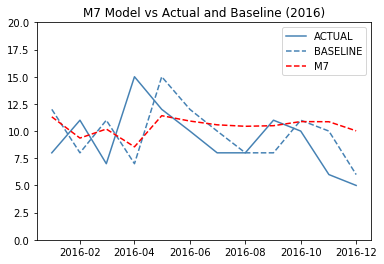

In [67]:
#Plot model results
plt.plot(df_M7_2016.DATE,df_M7_2016.ACTUAL,color = 'steelblue')
plt.plot(df_M7_2016.DATE,df_M7_2016.BASELINE,'--',color='steelblue')
plt.plot(df_M7_2016.DATE,df_M7_2016.M7, '--', color = 'red')
plt.title('M7 Model vs Actual and Baseline (2016)')
axes = plt.gca()
axes.set_ylim([0,20])
plt.legend()

In [73]:
#run model on the training set to produce the backtest
M7_RMSE,M7_pred,M7_actual = ts_walk_forward(training_X_scaled,training_y.values,15,15,regr_M7)

In [83]:
len(M7_pred),len(M7_actual),len(dfM.DATE[16:-12])

(104, 104, 104)

In [89]:
Baseline_training_RMSE = mean_squared_error(df_M7.ACTUAL,df_M7.BASELINE) ** 0.5

In [93]:
'Backtest on training set: 2006 - 2015'
print('Baseline RMSE: ',Baseline_training_RMSE)
print('      M7_RMSE: ',M7_RMSE)

Baseline RMSE:  4.81084512006
      M7_RMSE:  3.87382733108


In [77]:
df_M7 = pd.DataFrame({'DATE':dfM.DATE[16:-12],'ACTUAL':[i[0] for i in M7_actual],
                      'M7':[i[0] for i in M7_pred],
                     'BASELINE':dfM.t[16:-12]})

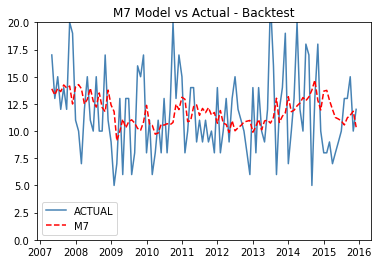

In [82]:
#Plot model results
plt.plot(df_M7.DATE,df_M7.ACTUAL,color = 'steelblue')
#plt.plot(df_M7.DATE,df_M7.BASELINE,'--',color='steelblue')
plt.plot(df_M7.DATE,df_M7.M7, '--', color = 'red')
plt.title('M7 Model vs Actual - Backtest')
axes = plt.gca()
axes.set_ylim([0,20])
plt.legend()

# Notes on model
1 - The model prediction isn't an integer and there cannot be partial crimes, so either integer programming is needed or results can be rounded to simplify    
2 - the spikes are generally not due to seasonality, it is possible there are features outside the data set that could better predict these.  

# Three Month Prediction
Use the model output for one month as input to the prediction 2 months out, and then again for three months out